# Systemic Racism: South Asians in Toronto and Unemployment

#### INF2199H - Critical and Human-Centred Approaches to Information Visualization

By Diego Mamanche Castellanos

## Content Table

1. Data Preprocessing
2. Misleading graph: Bar plot
3. Misleading graph: 2D map version
4. The Truth about South Asians
5. Conclusions

## 1 Data Preprocessing

In [110]:
#Import libraries
import pandas as pd
import requests
import matplotlib.pyplot as plt
import geopandas as gpd
import geodaisy.converters as convert #Convert geojson into polygon and viceversa
from PIL import Image               # to load images
from IPython.display import display # to display images
import folium
from shapely.geometry import Point, Polygon
from folium.plugins import FastMarkerCluster

### 1.1 The Neighbourhood profiles dataset

The neighbourhood profiles dataset uses Census data to provide a depiction of the demographic, social, and economic characteristics of the people and households in the City of Toronto. Each record contains a particular characteristic across all 140 Toronto's neighbourhoods represented as columns in this dataset.

Link: https://open.toronto.ca/dataset/neighbourhood-profiles/

#### 1.1.1 Loading the data

In [111]:
# Get the dataset metadata by passing package_id to the package_search endpoint
# For example, to retrieve the metadata for this dataset:

url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "6e19a90f-971c-46b3-852c-0c48c436d1fc"}
package = requests.get(url, params = params).json()
#print(package["result"])

In [112]:
# Get the data by passing the resource_id to the datastore_search endpoint
# See https://docs.ckan.org/en/latest/maintaining/datastore.html for detailed parameters options
# For example, to retrieve the data content for the first resource in the datastore:

for idx, resource in enumerate(package["result"]["resources"]):
    if resource["datastore_active"]:
        url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/datastore_search"
        p = { "id": resource["id"] , "limit":10000}
        data = requests.get(url, params = p).json()
        df = pd.DataFrame(data["result"]["records"])
        break
df.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,n/a,129,128,20,95,...,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,n/a,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,4,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,5,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


#### 1.1.2 Selecting the caterogies to be analyzed

In [113]:
visible_minority = df.loc[df.Topic.isin(['Visible minority population', 'Labour force status'])]
visible_minority.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
1147,1148,Visible minority,Visible minority population,Census Profile 98-316-X2016001,Latin American,"77,165",170,230,180,405,...,190,935,745,140,155,445,220,160,"1,765",710
1335,1336,Visible minority,Visible minority population,Census Profile 98-316-X2016001,Total - Visible minority for the population in...,"2,691,665","28,825","23,470","12,025","28,640",...,"16,670","22,150","53,005","12,435","7,850","13,250","11,805","12,300","27,570","14,030"
1336,1337,Visible minority,Visible minority population,Census Profile 98-316-X2016001,Total visible minority population,"1,385,855","26,365","20,155","2,490","7,270",...,"9,630","8,870","40,510","3,380","2,435","3,635","3,155","2,555","19,135","6,340"
1337,1338,Visible minority,Visible minority population,Census Profile 98-316-X2016001,South Asian,"338,965","5,315","4,190",540,"1,125",...,860,"2,340","21,545",610,345,255,445,560,"4,180",865
1338,1339,Visible minority,Visible minority population,Census Profile 98-316-X2016001,Chinese,"299,465","16,460","11,110",275,"2,145",...,"3,655",515,"3,715","1,025",730,805,980,575,"1,500",850


#### 1.1.3 Removing non-neighbourhood columns

In [114]:
#Remove columns 
clean_minority = visible_minority.drop(columns=['_id','Category','Topic','Data Source','City of Toronto'])

#Set chracteristics column as an index 
clean_minority = clean_minority.set_index('Characteristic')
clean_minority.head()

,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
Characteristic,,,,,,,,,,,,,,,,,,,,,
Latin American,170,230,180,405,350,575,460,410,150,345,...,190,935,745,140,155,445,220,160,"1,765",710
Total - Visible minority for the population in private households - 25% sample data,"28,825","23,470","12,025","28,640","26,995","15,580","25,605","21,140","12,655","23,115",...,"16,670","22,150","53,005","12,435","7,850","13,250","11,805","12,300","27,570","14,030"
Total visible minority population,"26,365","20,155","2,490","7,270","12,700","5,420","15,925","14,505","8,250","4,845",...,"9,630","8,870","40,510","3,380","2,435","3,635","3,155","2,555","19,135","6,340"
South Asian,"5,315","4,190",540,"1,125","2,825",550,"2,420","1,360",670,455,...,860,"2,340","21,545",610,345,255,445,560,"4,180",865
Chinese,"16,460","11,110",275,"2,145","4,630",655,"7,435","5,860","4,360","1,030",...,"3,655",515,"3,715","1,025",730,805,980,575,"1,500",850


#### 1.1.4 Transposing the data

This step is necessary to incorporate geo data about neighbourhoods.

In [115]:
# Transpose dataframe
clean_minority = clean_minority.T

#### 1.1.5 Cleaning data and creating joining key

In [116]:
#Remove commas from values stored as strings and change data type to float
clean_minority =  clean_minority.apply(lambda x: x.str.replace(',','').astype(float))

#Reset index and create column Neighbourhood
clean_minority = clean_minority.reset_index().rename({'index':'Neighbourhood'}, axis = 'columns')

In [117]:
clean_minority['joining_key'] = clean_minority.Neighbourhood.str.replace(r'([ -.\t]+)','').str.extract(r'([a-zA-Z ]+)', expand=False)

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [118]:
#Drop columns
clean_minority = clean_minority.drop(columns=['  Total visible minority population','Total - Visible minority for the population in private households - 25% sample data'])
clean_minority.head()

Characteristic,Neighbourhood,Latin American,South Asian,Chinese,Black,Filipino,Arab,Southeast Asian,West Asian,Korean,...,Unemployment rate (Males),Total - Population aged 15 years and over by Labour force status (Females) - 25% sample data,In the labour force (Females),Employed (Females),Unemployed (Females),Not in the labour force (Females),Participation rate (Females),Employment rate (Females),Unemployment rate (Females),joining_key
0,Agincourt North,170.0,5315.0,16460.0,1340.0,1420.0,275.0,260.0,125.0,70.0,...,9.0,13150.0,6770.0,6055.0,720.0,6375.0,51.5,46.0,10.6,AgincourtNorth
1,Agincourt South-Malvern West,230.0,4190.0,11110.0,1545.0,1280.0,300.0,155.0,375.0,140.0,...,8.8,10460.0,5715.0,5095.0,620.0,4750.0,54.6,48.7,10.8,AgincourtSouthMalvernWest
2,Alderwood,180.0,540.0,275.0,300.0,615.0,90.0,55.0,20.0,65.0,...,5.4,5230.0,3250.0,3030.0,220.0,1985.0,62.1,57.9,6.8,Alderwood
3,Annex,405.0,1125.0,2145.0,935.0,350.0,300.0,190.0,340.0,605.0,...,6.9,13865.0,9375.0,8755.0,625.0,4500.0,67.6,63.1,6.7,Annex
4,Banbury-Don Mills,350.0,2825.0,4630.0,970.0,1135.0,550.0,110.0,755.0,560.0,...,6.4,12685.0,6935.0,6370.0,570.0,5750.0,54.7,50.2,8.2,BanburyDonMills


### 1.2 The Neighbourhoods dataset

This dataset contains the boundaries of City of Toronto Neighbourhoods as GeoJSON.

Link: https://open.toronto.ca/dataset/neighbourhoods/

#### 1.2.1 Loading the data

In [119]:
# Get the dataset metadata by passing package_id to the package_search endpoint
# For example, to retrieve the metadata for this dataset:
 
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "4def3f65-2a65-4a4f-83c4-b2a4aed72d46"}
package = requests.get(url, params = params).json()
#print(package["result"])


In [120]:
# Get the data by passing the resource_id to the datastore_search endpoint
# See https://docs.ckan.org/en/latest/maintaining/datastore.html for detailed parameters options
# For example, to retrieve the data content for the first resource in the datastore:
 
for idx, resource in enumerate(package["result"]["resources"]):
    if resource["datastore_active"]:
        url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/datastore_search"
        p = { "id": resource["id"] , "limit":10000}
        data = requests.get(url, params = p).json()
        geo_data = pd.DataFrame(data["result"]["records"])
        break
geo_data.head()

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,geometry,CLASSIFICATION,CLASSIFICATION_CODE
0,11481,2480141,26005521,None,096,096,Casa Loma (96),Casa Loma (96),None,None,None,None,17545105,3.678385e+06,8214.176485,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4146...",None,None
1,11482,2480140,26005520,None,095,095,Annex (95),Annex (95),None,None,None,None,17545121,5.337192e+06,10513.883143,"{""type"": ""Polygon"", ""coordinates"": [[[-79.3941...",None,None
2,11483,2480139,26005519,None,109,109,Caledonia-Fairbank (109),Caledonia-Fairbank (109),None,None,None,None,17545137,2.955857e+06,6849.911724,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4602...",None,None
3,11484,2480064,26005444,None,064,064,Woodbine Corridor (64),Woodbine Corridor (64),None,None,None,None,17545153,3.052518e+06,7512.966773,"{""type"": ""Polygon"", ""coordinates"": [[[-79.3148...",None,None
4,11485,2480063,26005443,None,103,103,Lawrence Park South (103),Lawrence Park South (103),None,None,None,None,17545169,6.211341e+06,13530.370002,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4109...",None,None


#### 1.2.2 Creating the joining key

In [121]:
#Remove special characters and create column "joining_key"
geo_data['joining_key'] = geo_data.AREA_NAME.str.replace(r'([ -.\t]+)','').str.extract(r'([a-zA-Z ]+)', expand=False)

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [122]:
#Change manually the neighbourhood name WestonPellamPark to WestonPelhamPark
geo_data['joining_key'].iloc[40] = 'WestonPelhamPark'
geo_data['joining_key'].iloc[40]

C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


'WestonPelhamPark'

### 1.3 Combine datasets and create a geodataframe

To plot different characteristics of the neighbourhoods on a map, it is necessary to merge both datasets, creating a new dataset.

#### 1.3.1 Merging datasets

In [123]:
final_df = pd.merge(clean_minority,geo_data[['joining_key','geometry']], on='joining_key', how='left')
final_df.columns = final_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  


#### 1.3.2 Convert values from geometry column into polygons

In [124]:
final_df['geometry'] = final_df['geometry'].apply(lambda x: convert.geojson_to_wkt(x))
final_df.head()

,neighbourhood,latin_american,south_asian,chinese,black,filipino,arab,southeast_asian,west_asian,korean,...,total_-_population_aged_15_years_and_over_by_labour_force_status_females_-_25%_sample_data,in_the_labour_force_females,employed_females,unemployed_females,not_in_the_labour_force_females,participation_rate_females,employment_rate_females,unemployment_rate_females,joining_key,geometry
0,Agincourt North,170.0,5315.0,16460.0,1340.0,1420.0,275.0,260.0,125.0,70.0,...,13150.0,6770.0,6055.0,720.0,6375.0,51.5,46.0,10.6,AgincourtNorth,"POLYGON ((-79.2421274578355 43.8024720055488, ..."
1,Agincourt South-Malvern West,230.0,4190.0,11110.0,1545.0,1280.0,300.0,155.0,375.0,140.0,...,10460.0,5715.0,5095.0,620.0,4750.0,54.6,48.7,10.8,AgincourtSouthMalvernWest,"POLYGON ((-79.2549798538438 43.781222537134, -..."
2,Alderwood,180.0,540.0,275.0,300.0,615.0,90.0,55.0,20.0,65.0,...,5230.0,3250.0,3030.0,220.0,1985.0,62.1,57.9,6.8,Alderwood,"POLYGON ((-79.5486574524656 43.5902161012798, ..."
3,Annex,405.0,1125.0,2145.0,935.0,350.0,300.0,190.0,340.0,605.0,...,13865.0,9375.0,8755.0,625.0,4500.0,67.6,63.1,6.7,Annex,"POLYGON ((-79.3941414134356 43.6687202679382, ..."
4,Banbury-Don Mills,350.0,2825.0,4630.0,970.0,1135.0,550.0,110.0,755.0,560.0,...,12685.0,6935.0,6370.0,570.0,5750.0,54.7,50.2,8.2,BanburyDonMills,"POLYGON ((-79.3305547263443 43.7397898788133, ..."


#### 1.3.3 Creating a geodataframe

In [125]:
final_df['geometry'] = gpd.GeoSeries.from_wkt(final_df['geometry'])
minority_geo_df = gpd.GeoDataFrame(final_df, geometry='geometry')

In [126]:
minority_geo_df.head()

,neighbourhood,latin_american,south_asian,chinese,black,filipino,arab,southeast_asian,west_asian,korean,...,total_-_population_aged_15_years_and_over_by_labour_force_status_females_-_25%_sample_data,in_the_labour_force_females,employed_females,unemployed_females,not_in_the_labour_force_females,participation_rate_females,employment_rate_females,unemployment_rate_females,joining_key,geometry
0,Agincourt North,170.0,5315.0,16460.0,1340.0,1420.0,275.0,260.0,125.0,70.0,...,13150.0,6770.0,6055.0,720.0,6375.0,51.5,46.0,10.6,AgincourtNorth,"POLYGON ((-79.24213 43.80247, -79.24319 43.802..."
1,Agincourt South-Malvern West,230.0,4190.0,11110.0,1545.0,1280.0,300.0,155.0,375.0,140.0,...,10460.0,5715.0,5095.0,620.0,4750.0,54.6,48.7,10.8,AgincourtSouthMalvernWest,"POLYGON ((-79.25498 43.78122, -79.25797 43.780..."
2,Alderwood,180.0,540.0,275.0,300.0,615.0,90.0,55.0,20.0,65.0,...,5230.0,3250.0,3030.0,220.0,1985.0,62.1,57.9,6.8,Alderwood,"POLYGON ((-79.54866 43.59022, -79.54876 43.590..."
3,Annex,405.0,1125.0,2145.0,935.0,350.0,300.0,190.0,340.0,605.0,...,13865.0,9375.0,8755.0,625.0,4500.0,67.6,63.1,6.7,Annex,"POLYGON ((-79.39414 43.66872, -79.39588 43.668..."
4,Banbury-Don Mills,350.0,2825.0,4630.0,970.0,1135.0,550.0,110.0,755.0,560.0,...,12685.0,6935.0,6370.0,570.0,5750.0,54.7,50.2,8.2,BanburyDonMills,"POLYGON ((-79.33055 43.73979, -79.33044 43.739..."


## 2 Misleading graph: Bar plot

This sketch tries to plot the top three neighbourhoods with the highest number of unemployed people who, at the same time, are located in the neighbourhoods with the highest number of South Asians. This method is limited to the top-3 approach because only with this top-3 we demonstrate South Asians are the most marginalized people.

<AxesSubplot:xlabel='neighbourhood'>

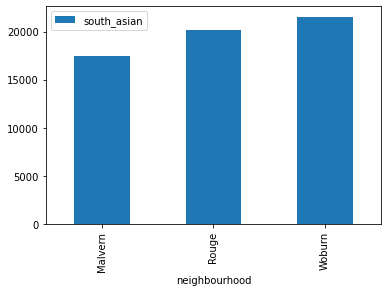

In [163]:
top3_south_asian = final_df.loc[final_df['south_asian'].isin(final_df['south_asian'].nlargest(3))]
top3_south_asian = top3_south_asian[['neighbourhood','south_asian']]
top3_south_asian.plot.bar('neighbourhood','south_asian', legend=True)

<AxesSubplot:xlabel='neighbourhood'>

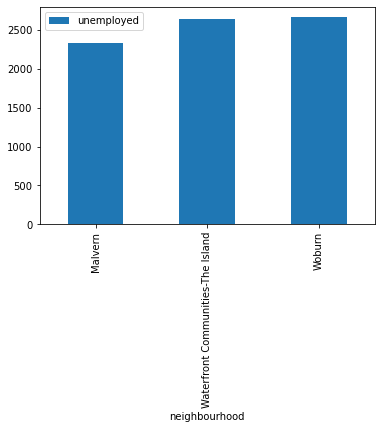

In [162]:
top3_unemployed = final_df.loc[final_df['unemployed'].isin(final_df['unemployed'].nlargest(3))]
top3_unemployed = top3_unemployed[['neighbourhood','unemployed']]
top3_unemployed.plot.bar('neighbourhood','unemployed')

## 3 Misleading graph: 2D map version

Once created the GeoDataframe several characteristics can be sketched. For this analysis, we will focus on the population, particularly South Asians and unemployed people by neighbourhood.

#### 3.1 Plotting a real-scale map (no modifications)

When plotting a real-scale map, we see South Asians are mostly located at the borders (East and West), but we still observe the South Asian population distributed across all neighbourhoods. Moreover, unemployed people are spread across several neighbourhoods. However, we can see some of the darkest zones overlap with aforementioned South Asian neighbourhoods.

<AxesSubplot:title={'center':'Real numbers about unemployed people living in Toronto'}>

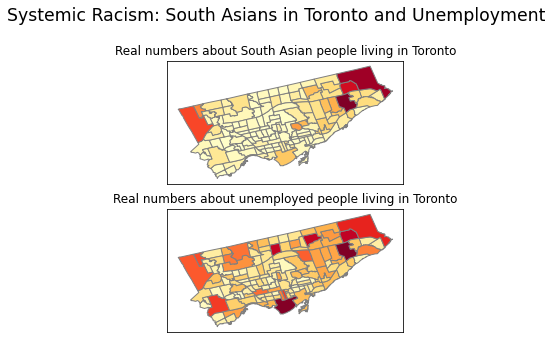

In [127]:
# Plot south_asian and unemployed columns as subplots
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

fig1.suptitle('Systemic Racism: South Asians in Toronto and Unemployment', ha="center", va="bottom", size="xx-large")

ax1.axes.get_yaxis().set_visible(False)
ax1.axes.get_xaxis().set_visible(False)

ax2.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)

ax1.title.set_text('Real numbers about South Asian people living in Toronto')
ax2.title.set_text('Real numbers about unemployed people living in Toronto')

minority_geo_df.plot('south_asian', cmap = 'YlOrRd', legend = False, edgecolor='gray', ax=ax1)
minority_geo_df.plot('unemployed', cmap = 'YlOrRd', legend = False, edgecolor='gray', ax=ax2)

#### 3.2 Plotting a manipulated colormap-range map

On this occasion, to take advantage of the identified neighbourhoods where most South Asians are located and overlap with high-unemployed neighbourhoods, we have limited the colormap range. The idea is to fix the range making darker the values above the maximum value and lighter the one under the minimum value. By doing this, we have emphasized the zones we are interested in, making the other ones less relevant.

<AxesSubplot:title={'center':'Where most unemployed people live in Toronto'}>

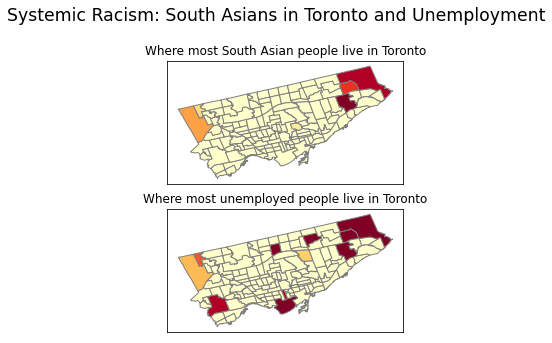

In [128]:
# Plot south_asian and unemployed columns as subplots
fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

fig2.suptitle('Systemic Racism: South Asians in Toronto and Unemployment', ha="center", va="bottom", size="xx-large")

ax1.axes.get_yaxis().set_visible(False)
ax1.axes.get_xaxis().set_visible(False)

ax2.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)

ax1.title.set_text('Where most South Asian people live in Toronto')
ax2.title.set_text('Where most unemployed people live in Toronto')

#Plot south_asian column with a vmax = 8000
minority_geo_df.plot('south_asian', cmap = 'YlOrRd', legend = False, vmin=8000, edgecolor='gray', ax=ax1)

#Plot unemployed column with a vmin = 1600 vmax = 1900
minority_geo_df.plot('unemployed', cmap = 'YlOrRd', legend = False, k = 2, vmin=1600, vmax=1900, edgecolor='gray', ax=ax2)

## 4 The truth about South Asians

Visible minorities such as South Asian people are affected by unemployment, but it is not the only one. Moreover, having the majority of South Asians located in particular neighbourhoods does not mean those are particularly South Asian neighbourhoods. For instance, black people also live in the same zones, as it is shown in the following figure.

<AxesSubplot:>

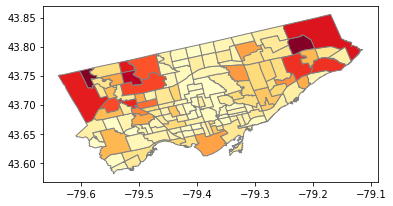

In [129]:
minority_geo_df.plot('black', cmap = 'YlOrRd', legend = False, edgecolor='gray')

Furthermore, as we will see in the next set of plots, the neighbourhood with the highest number of employed people is also the highest for unemployed. It means we are using the wrong approach to illustrate systemic racism if present at all.

<AxesSubplot:title={'center':'Unemployed people living in Toronto'}>

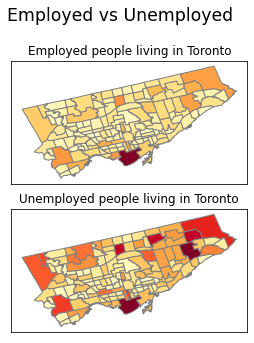

In [130]:
# Plot south_asian and unemployed columns as subplots
fig3, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

fig3.suptitle('Employed vs Unemployed', ha="center", va="bottom", size="xx-large")

ax1.axes.get_yaxis().set_visible(False)
ax1.axes.get_xaxis().set_visible(False)

ax2.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)

ax1.title.set_text('Employed people living in Toronto')
ax2.title.set_text('Unemployed people living in Toronto')

minority_geo_df.plot('employed', cmap = 'YlOrRd', legend = False, edgecolor='gray', ax=ax1)
minority_geo_df.plot('unemployed', cmap = 'YlOrRd', legend = False, edgecolor='gray', ax=ax2)

Finally, as mentioned before, if the wrong approach is taken it is easy to be mistaken about the data. In this case, it is better to use the rate rather than the number of people. For instance, if we use employment and unemployment rates, we can have a better picture of employment distribution in Toronto. In the following figure, we will see that the same neighbourhoods highlighted as South Asians in section 3.2, are fairly distributed between employment and unemployment.

<AxesSubplot:title={'center':'Unemployement rate by neighbourhood in Toronto'}>

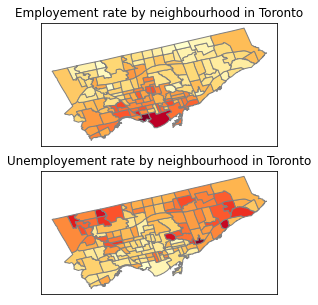

In [131]:
# Plot south_asian and unemployed columns as subplots
fig4, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

ax1.axes.get_yaxis().set_visible(False)
ax1.axes.get_xaxis().set_visible(False)

ax2.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)

ax1.title.set_text('Employement rate by neighbourhood in Toronto')
ax2.title.set_text('Unemployement rate by neighbourhood in Toronto')

minority_geo_df.plot('employment_rate', cmap = 'YlOrRd', legend = False, edgecolor='gray', ax=ax1)
minority_geo_df.plot('unemployment_rate', cmap = 'YlOrRd', legend = False, edgecolor='gray', ax=ax2)

## 5 Conclusions and future work

### 5.1 Color map for segmentation

After applying colormap manipulations to the graphs, I have found this practice a powerful tool to emphasize the aspects of the plot for the message I want to convey. But at the same time, a weapon to mislead people's reasoning.

### 5.2 Best Misleading graph

Based on the different sketches created during this analysis, we can see that the figure from section 3.2 is the best approach. It can be easily used to transmit the message about South Asians and unemployment in Toronto.

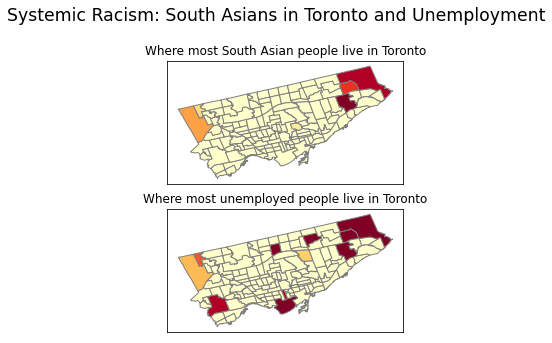

In [132]:
fig2

### 5.3 Future work: 3D maps

A 3D map provides a realistic location image that can be utilized to grab people's attention. As most neighbourhoods data is numeric, we can create amazing plots. The following illustration is an example of it.

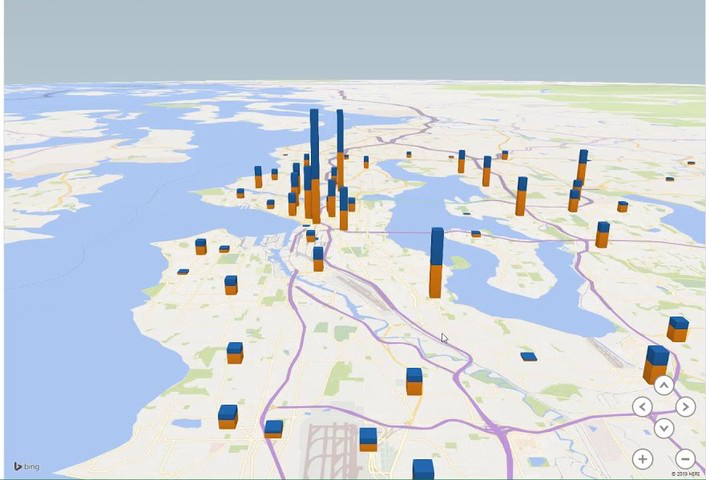

In [133]:
pil_img = Image.open('3dmap.jpg', 'r')
display(pil_img)